### **0. Notebook Overview and Learning Goals**

In the previous notebook, we learned how to perform **feature extraction** — using a pretrained model as a fixed feature generator and training only the final classifier head on our Caltech-101 subset.  
Now, we take the next conceptual step: **fine-tuning**.

Fine-tuning is the process of *partially unfreezing* a pretrained model so that some of its layers can adapt to the new dataset.  
Instead of keeping the entire convolutional backbone frozen, we’ll allow a few of its deeper layers to learn again, but at a **very small learning rate**.  
This helps the model slightly reshape its internal representations while still retaining most of its pretrained knowledge.

**Why fine-tune?**

Feature extraction works well when our target dataset is **similar** to the source dataset (e.g., both contain natural images).  
However, if our dataset has new textures, shapes, or styles that differ from ImageNet, we might want to *fine-tune* the deeper layers so the model adapts to these new characteristics.

Fine-tuning lets us:
- Refine learned representations for our specific task.
- Achieve better accuracy for certain hard-to-classify categories.
- Explore how pretrained features evolve when allowed to learn slightly.

**What we’ll accomplish in this notebook**

We will:
1. **Reload the trained checkpoint** from the feature extraction stage (NB02).  
2. **Unfreeze the final residual block** (`layer4`) of ResNet18.  
3. **Train with a smaller learning rate** to adjust weights carefully.  
4. **Compare results** with the feature extraction stage (accuracy, confusion matrix).  
5. **Visualize feature changes** and discuss when fine-tuning is beneficial.


> **Key idea:**  
> Feature extraction reuses pretrained knowledge; fine-tuning *adapts* it.  
> In this notebook, we’ll experience this transition firsthand and reflect on its impact.


---

### **1. From Feature Extraction to Fine-Tuning**

Let’s recall what we did previously.  
In the last notebook, we **froze all pretrained layers** of ResNet18 and trained only the **new classifier head**.  
That approach was called **feature extraction** because the pretrained backbone acted as a fixed feature generator — it transformed each image into a rich, high-level representation, and only the classifier learned to map those representations to our new classes.

Now, we take a step forward and begin **fine-tuning**.

**Feature Extraction vs. Fine-Tuning**

We can summarize the transition as follows:

> **Before (Feature Extraction)**  
> Frozen backbone → Trained head  
>
> **Now (Fine-Tuning)**  
> Partially unfrozen backbone → Trained head  

In feature extraction, the weights of the convolutional layers remain **frozen** — they do not receive gradient updates.  
Fine-tuning means we selectively **unfreeze** some layers (usually the deeper ones) so that they can *slightly adjust* to the characteristics of our new dataset.  

This adaptation lets the model learn subtle differences — new textures, object shapes, or lighting conditions — that were not present in the original ImageNet training data.

**Why Only Unfreeze the Deeper Layers?**

The early layers of a CNN learn very **generic features**, like:
- edges,  
- corners,  
- simple color gradients.  

These are universal across images and do not need retraining.

The **deeper layers**, however, learn **task-specific features**, such as the shape of animal faces or car parts.  
These are the layers that we want to adapt — just a little — to suit our new task.

Hence, we typically unfreeze only the **last few layers** (like `layer4` in ResNet18), keeping earlier ones fixed.

**The Risk: Catastrophic Forgetting**

Fine-tuning must be done carefully.  
If the learning rate is too high, the pretrained weights can be overwritten — causing the model to “forget” the general features it had learned from ImageNet.  
This phenomenon is called **catastrophic forgetting**.

That’s why, during fine-tuning, we use:
- a **small learning rate** (e.g., $1\times10^{-4}$ or lower),
- careful layer selection (usually just the top block),
- and limited epochs.

**Analogy: A Musician’s Skill Refinement**

Think of a pretrained model as an experienced musician.  
They already know rhythm, pitch, and timing — the *universal skills*.  
Now, if they want to play a new style, say jazz instead of classical, we don’t retrain them from scratch.  
We **refine** just the high-level techniques — improvisation, timing flexibility, new chord progressions — without undoing their foundational training.

Fine-tuning works exactly like that:  
we keep the fundamentals intact, but adjust the *high-level understanding* to better fit the new domain.

> **In short:**  
> Fine-tuning = *feature reuse + gentle adaptation*.  
> It’s the art of improving without forgetting.


---

### **2. Reloading the Feature Extraction Checkpoint**

In NB02 we saved a checkpoint that contains:
- the **pretrained backbone** (ResNet18) kept **frozen**, and
- the **trained classifier head** for our 10 Caltech classes,
- plus a **class-to-index mapping** to keep label ordering consistent.

Here we will:
1. **Load** the checkpoint and class mapping.  
2. **Rebuild** the dataloaders (train/val/test) using the same preprocessing as before.  
3. **Freeze all layers**, then **unfreeze only the last residual block** `layer4` so that the deepest features can adapt.  
4. **Verify** which parameters are trainable vs frozen and print a short summary.

> We will not reuse the NB02 optimizer state, because fine-tuning uses **different learning rates** (smaller for pretrained layers). We will create a fresh optimizer in the next section.


**Load mapping, datasets, and dataloaders (same transforms as NB02)**

In [1]:
import torch, json
from pathlib import Path
from torchvision import datasets, transforms

# Paths (must match NB01/NB02)
DATA_ROOT = Path("./data/caltech101_10")
CKPT_DIR  = Path("./checkpoints")
FT_LOAD_PATH = CKPT_DIR / "resnet18_feature_extraction.pth"  # saved at the end of NB02
MAP_PATH      = CKPT_DIR / "class_to_idx.pth"                # saved in NB01

assert DATA_ROOT.exists(), f"Missing dataset at {DATA_ROOT}"
assert FT_LOAD_PATH.exists(), f"Missing NB02 checkpoint at {FT_LOAD_PATH}"
assert MAP_PATH.exists(), f"Missing class_to_idx mapping at {MAP_PATH}"

# Load class mapping → stable label order
class_to_idx = torch.load(MAP_PATH, weights_only=False)
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
num_classes = len(class_names)
print(f"[info] Classes ({num_classes}): {class_names}")

# Transforms (ImageNet-compatible) — same as NB01/NB02
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Datasets & DataLoaders
train_ds = datasets.ImageFolder(DATA_ROOT / "train", transform=transform)
val_ds   = datasets.ImageFolder(DATA_ROOT / "val",   transform=transform)
test_ds  = datasets.ImageFolder(DATA_ROOT / "test",  transform=transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

print(f"[info] Dataset sizes → train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")


[info] Classes (10): ['Faces', 'Motorbikes', 'airplanes', 'butterfly', 'camera', 'chair', 'laptop', 'lotus', 'panda', 'watch']
[info] Dataset sizes → train=964, val=209, test=204


**Recreate model, load NB02 weights, freeze all, then unfreeze only layer4**

Before we unfreeze `layer4`, let’s recall **how ResNet-18 is organized**.  
This model consists of a *stem* (early convolutional layers) followed by **four sequential residual blocks**, each deeper and more abstract than the last.

**ResNet-18 Architecture Overview**

| Stage | Name | Typical Output Size | Description | Trainable Status |
|:------:|:------|:------------------:|:-------------|:----------------|
| 1 | `conv1` + `bn1` + `relu` + `maxpool` | 64×56×56 | Initial convolutional stem extracting low-level edges and textures | ❌ Frozen |
| 2 | `layer1` | 64×56×56 | First residual block — still low-level spatial features | ❌ Frozen |
| 3 | `layer2` | 128×28×28 | Mid-level features — shapes, textures, and contours | ❌ Frozen |
| 4 | `layer3` | 256×14×14 | Higher-level patterns and object parts | ❌ Frozen |
| 5 | `layer4` | 512×7×7 | Deepest convolutional block — object-level abstractions | ✅ To be Unfrozen |
| 6 | `avgpool` + `fc` | 512→`num_classes` | Global pooling + final classifier | ✅ Unfrozen |

**Why unfreeze only `layer4`?**
- Earlier layers capture **generic visual features** (edges, color blobs) that are transferable across datasets.  
- Deeper layers (especially `layer4`) encode **dataset-specific semantics**, so fine-tuning this part helps the model adapt to our Caltech-10 classes without overfitting or retraining the entire network.  
- This approach is called **“partial fine-tuning”** — it balances generalization and adaptation.

> In short:  
> - `layer1–3` = reusable backbone features (frozen)  
> - `layer4 + fc` = task-specific features (trainable)


In [2]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Start from the same architecture
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 2) Resize the classifier head to our classes (same as NB02)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# 3) Load NB02 checkpoint (feature extraction result: frozen backbone + trained head)
state = torch.load(FT_LOAD_PATH, weights_only=False, map_location="cpu")
model.load_state_dict(state, strict=True)

# 4) Freeze everything first
for p in model.parameters():
    p.requires_grad = False

# 5) Unfreeze only the final residual block (layer4) and the classifier head
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

model = model.to(device)
model.eval()

print("[info] Loaded NB02 checkpoint and set trainable layers: layer4 + fc")

[info] Loaded NB02 checkpoint and set trainable layers: layer4 + fc


**Print a compact summary of trainable vs frozen parameters**

In [3]:
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params    = total_params - trainable_params

trainable_names = [n for n, p in model.named_parameters() if p.requires_grad]

print(f"[summary] Total parameters:     {total_params:,}")
print(f"[summary] Trainable parameters: {trainable_params:,}")
print(f"[summary] Frozen parameters:    {frozen_params:,}")
print("[summary] Trainable tensors:")
for n in trainable_names:
    print("  -", n)

# Safety: ensure only layer4 and fc are trainable
assert all(n.startswith("layer4.") or n.startswith("fc.") for n in trainable_names), \
    "Unexpected trainable layers detected (only layer4 and fc should be trainable)."

print("[check] Trainability looks correct (only layer4 + fc).")


[summary] Total parameters:     11,181,642
[summary] Trainable parameters: 8,398,858
[summary] Frozen parameters:    2,782,784
[summary] Trainable tensors:
  - layer4.0.conv1.weight
  - layer4.0.bn1.weight
  - layer4.0.bn1.bias
  - layer4.0.conv2.weight
  - layer4.0.bn2.weight
  - layer4.0.bn2.bias
  - layer4.0.downsample.0.weight
  - layer4.0.downsample.1.weight
  - layer4.0.downsample.1.bias
  - layer4.1.conv1.weight
  - layer4.1.bn1.weight
  - layer4.1.bn1.bias
  - layer4.1.conv2.weight
  - layer4.1.bn2.weight
  - layer4.1.bn2.bias
  - fc.weight
  - fc.bias
[check] Trainability looks correct (only layer4 + fc).


We reloaded the **feature extraction** weights (NB02) so the classifier head starts from its trained state and the backbone retains its pretrained knowledge.  

By **unfreezing only `layer4`** we allow the deepest features to adapt *slightly* to our dataset, while early/mid layers remain stable.  

This is a safe, effective recipe to improve performance without risking catastrophic forgetting.


---

**✅ Code Task 11.3.2.1: Unfreeze layer3 + layer4 + fc in a fresh model**

**Instruction**: Recreate a new ResNet18 model using the NB02 checkpoint, but store it in `CT_model`.
Freeze all layers, then unfreeze both layer3, layer4, and fc, and compute the total, trainable, and frozen parameter counts.

In [ ]:
from torchvision import models
import torch.nn as nn

# 1) Start from same base architecture as NB02
CT_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 2) Resize classifier head to our number of classes
CT_in_features = CT_model.fc.in_features
CT_model.fc = nn.Linear(CT_in_features, num_classes)

# 3) Load NB02 checkpoint (feature extraction weights)
CT_state = torch.load(FT_LOAD_PATH, weights_only=False, map_location="cpu")
CT_model.load_state_dict(CT_state, strict=...)

# 4) First freeze ALL parameters
for CT_p in CT_model.parameters():
    CT_p.requires_grad = ...

# 5) Unfreeze layer3, layer4 and fc
for CT_p in CT_model.layer3.parameters():
    CT_p.requires_grad = ...
for CT_p in CT_model.layer4.parameters():
    CT_p.requires_grad = ...
for CT_p in CT_model.fc.parameters():
    CT_p.requires_grad = ...

CT_model = CT_model.to(device)

# 6) Compute parameter counts
CT_total_params = ...
CT_trainable_params = ...
CT_frozen_params = ...

print(f"[CT_Task1] Total params:     {CT_total_params:,}")
print(f"[CT_Task1] Trainable params: {CT_trainable_params:,}")
print(f"[CT_Task1] Frozen params:    {CT_frozen_params:,}")


**Instructor Solution**

In [4]:
from torchvision import models
import torch.nn as nn

CT_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
CT_in_features = CT_model.fc.in_features
CT_model.fc = nn.Linear(CT_in_features, num_classes)

CT_state = torch.load(FT_LOAD_PATH, weights_only=False, map_location="cpu")
CT_model.load_state_dict(CT_state, strict=True)

for CT_p in CT_model.parameters():
    CT_p.requires_grad = False

for CT_p in CT_model.layer3.parameters():
    CT_p.requires_grad = True
for CT_p in CT_model.layer4.parameters():
    CT_p.requires_grad = True
for CT_p in CT_model.fc.parameters():
    CT_p.requires_grad = True

CT_model = CT_model.to(device)

CT_total_params = sum(p.numel() for p in CT_model.parameters())
CT_trainable_params = sum(p.numel() for p in CT_model.parameters() if p.requires_grad)
CT_frozen_params = CT_total_params - CT_trainable_params

print(f"[CT_Task1] Total params:     {CT_total_params:,}")
print(f"[CT_Task1] Trainable params: {CT_trainable_params:,}")
print(f"[CT_Task1] Frozen params:    {CT_frozen_params:,}")


[CT_Task1] Total params:     11,181,642
[CT_Task1] Trainable params: 10,498,570
[CT_Task1] Frozen params:    683,072


In [ ]:
assert 'CT_model' in globals(), "❌ CT_model not found. Did you create the fine-tuning model?"
assert 'CT_total_params' in globals(), "❌ CT_total_params missing."
assert 'CT_trainable_params' in globals(), "❌ CT_trainable_params missing."
assert 'CT_frozen_params' in globals(), "❌ CT_frozen_params missing."

# Check requires_grad pattern
for name, p in CT_model.named_parameters():
    if name.startswith("layer3.") or name.startswith("layer4.") or name.startswith("fc."):
        assert p.requires_grad, f"❌ {name} should be trainable (requires_grad=True)."
    else:
        assert not p.requires_grad, f"❌ {name} should be frozen (requires_grad=False)."

# Check parameter counts are consistent with the model
_ct_total = sum(p.numel() for p in CT_model.parameters())
_ct_trainable = sum(p.numel() for p in CT_model.parameters() if p.requires_grad)
_ct_frozen = _ct_total - _ct_trainable

assert CT_total_params == _ct_total, "❌ CT_total_params does not match model parameter count."
assert CT_trainable_params == _ct_trainable, "❌ CT_trainable_params incorrect."
assert CT_frozen_params == _ct_frozen, "❌ CT_frozen_params incorrect."
print("✅ CT_Task 1 passed!")


---

### **3. Optimizer, Learning Rate, and Scheduler**

When we fine-tune a pretrained model, our goal is to **adapt** higher-level features without destroying the knowledge learned during pretraining.  
To achieve this, we use **small learning rates** for the unfrozen pretrained layers so that weight updates are **gentle** and do not cause catastrophic forgetting.

A practical recipe is to use **differential learning rates**:
- A **lower LR** for the unfrozen pretrained layers (here, `layer4`, e.g., $1\times 10^{-4}$).  
- A **slightly higher LR** for the new classifier head (e.g., $1\times 10^{-3}$), since it was not pretrained and can move faster.

We keep the same **criterion** as before: `nn.CrossEntropyLoss()` for multi-class classification.

Optionally, we add a simple scheduler such as `StepLR` to **decay the learning rate** after a couple of epochs. This helps stabilize training and can yield a small boost in generalization.

> Intuition: with a smaller LR on `layer4`, we “nudge” the deepest features to better fit our dataset, while the classifier head adjusts more quickly to those adapted features.


**Set up criterion, differential LRs, and optional scheduler**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Loss function (same as NB02)
criterion = nn.CrossEntropyLoss()

# Differential learning rates:
# - layer4 (pretrained, now unfrozen): small LR
# - fc (head): larger LR
param_groups = [
    {"params": model.layer4.parameters(), "lr": 1e-4, "weight_decay": 1e-4},
    {"params": model.fc.parameters(),     "lr": 1e-3, "weight_decay": 1e-4},
]

optimizer = optim.Adam(param_groups)

# Optional scheduler for gentle LR decay
use_scheduler = True
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) if use_scheduler else None

# Small helper to print current learning rates per group
def get_lrs(optim_obj):
    return [group["lr"] for group in optim_obj.param_groups]

print("[ok] Optimizer set with differential LRs.")
print("     LRs per group (layer4, fc):", get_lrs(optimizer))


[ok] Optimizer set with differential LRs.
     LRs per group (layer4, fc): [0.0001, 0.001]


---

### **4. Fine-Tuning Training Loop**

We now adapt the **training–validation loop** from NB02 to fine-tune both the **classifier head** and **`layer4`**.  
Because we are updating some pretrained layers (with a **small learning rate**), convergence may be **slightly slower initially** than head-only training, but it can settle at a **better plateau** if our dataset benefits from representation adaptation.

We will:
- Train for **3–4 epochs on CPU** (short, controlled run).  
- Log `train_loss`, `val_loss`, and `val_acc` per epoch.  
- **Visualize** the curves and, if available, **compare** with NB02’s feature-extraction history.

What should we expect?
- If the target classes differ from ImageNet in textures/shapes, fine-tuning helps the deeper filters specialize for those **Caltech-specific cues**.  
- If the domain is already very close, gains might be small; the model could plateau near the head-only performance.

We keep `torch.no_grad()` for validation, and we step the scheduler (if used) **after** each epoch.


**Train/Eval helpers (fine-tuning)**

In [5]:
import torch
import torch.nn.functional as F

def ft_train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total = 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        # Forward
        logits = model(xb)
        loss = criterion(logits, yb)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate
        bs = xb.size(0)
        running_loss += loss.item() * bs
        total += bs

    return running_loss / max(total, 1)


@torch.no_grad()
def ft_evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        bs = xb.size(0)
        running_loss += loss.item() * bs
        total += bs

        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

    return running_loss / max(total, 1), correct / max(total, 1)


**Run fine-tuning (5-10 epochs, CPU-friendly)**

In [8]:
import time

num_epochs_ft = 5  
ft_history = {"train_loss": [], "val_loss": [], "val_acc": []}

print(f"[start] Fine-tuning layer4 + head for {num_epochs_ft} epochs...")
t_start = time.time()

for epoch in range(1, num_epochs_ft + 1):
    t0 = time.time()

    tr_loss = ft_train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = ft_evaluate(model, val_loader, criterion, device)

    if scheduler is not None:
        scheduler.step()

    ft_history["train_loss"].append(tr_loss)
    ft_history["val_loss"].append(va_loss)
    ft_history["val_acc"].append(va_acc)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d} | "
          f"train_loss={tr_loss:.4f} | "
          f"val_loss={va_loss:.4f} | "
          f"val_acc={va_acc:.3f} | "
          f"epoch_time={dt:.1f}s | LRs={ [g['lr'] for g in optimizer.param_groups] }")

print(f"[done] Finished fine-tuning in {time.time() - t_start:.1f}s")


[start] Fine-tuning layer4 + head for 5 epochs...
Epoch 01 | train_loss=0.1019 | val_loss=0.0206 | val_acc=0.990 | epoch_time=50.1s | LRs=[0.0001, 0.001]
Epoch 02 | train_loss=0.0134 | val_loss=0.0191 | val_acc=0.986 | epoch_time=42.4s | LRs=[5e-05, 0.0005]
Epoch 03 | train_loss=0.0083 | val_loss=0.0288 | val_acc=0.981 | epoch_time=47.7s | LRs=[5e-05, 0.0005]
Epoch 04 | train_loss=0.0032 | val_loss=0.0169 | val_acc=0.995 | epoch_time=52.9s | LRs=[2.5e-05, 0.00025]
Epoch 05 | train_loss=0.0056 | val_loss=0.0169 | val_acc=0.995 | epoch_time=44.0s | LRs=[2.5e-05, 0.00025]
[done] Finished fine-tuning in 237.1s


**Plot curves and (optionally) compare with NB02**

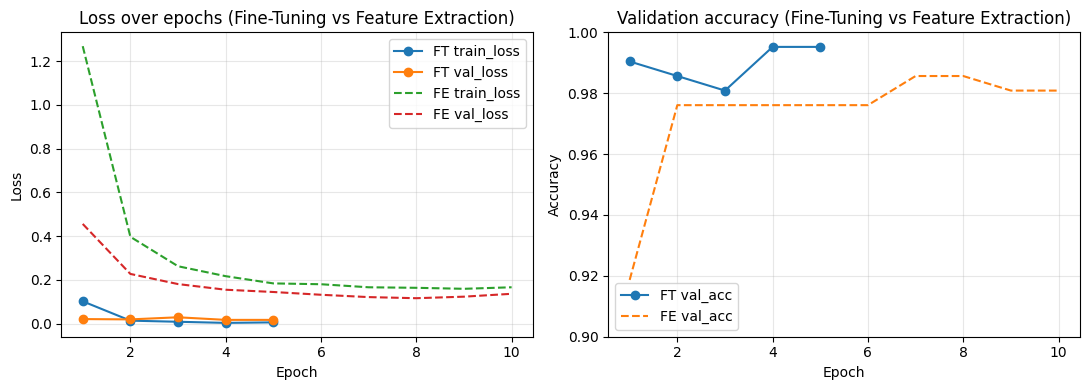

In [9]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Try to load NB02 logs for comparison, if present
fe_logs_path = Path("./checkpoints/training_logs_feature_extraction.json")
fe_logs = None
if fe_logs_path.exists():
    with open(fe_logs_path, "r") as f:
        fe_logs = json.load(f)

epochs_ft = range(1, len(ft_history["train_loss"]) + 1)

plt.figure(figsize=(11, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_ft, ft_history["train_loss"], marker="o", label="FT train_loss")
plt.plot(epochs_ft, ft_history["val_loss"], marker="o", label="FT val_loss")
if fe_logs is not None:
    e_fe = range(1, len(fe_logs["train_loss"]) + 1)
    plt.plot(e_fe, fe_logs["train_loss"], "--", label="FE train_loss")
    plt.plot(e_fe, fe_logs["val_loss"], "--", label="FE val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs (Fine-Tuning vs Feature Extraction)")
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_ft, ft_history["val_acc"], marker="o", label="FT val_acc")
if fe_logs is not None:
    e_fe = range(1, len(fe_logs["val_acc"]) + 1)
    plt.plot(e_fe, fe_logs["val_acc"], "--", label="FE val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy (Fine-Tuning vs Feature Extraction)")
plt.ylim(0.9, 1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Reading the curves**

 - If **fine-tuning** helps, we typically see **val_loss** end lower and **val_acc** end higher than feature extraction (FE).  
 - The first epoch or two may be **slower** because we are updating part of the backbone with a **small LR**.  
 - If FT curves **overfit** (train loss ↓ while val loss ↑), consider fewer epochs, stronger regularization, or milder unfreezing (e.g., only part of `layer4`).

**Why can FT beat FE?**  
Because the deeper filters in `layer4` can **specialize** to Caltech-specific shapes, textures, and backgrounds, improving separability where FE’s fixed features were not optimal.


---

**✅ Code Task 11.3.4.1 – Continue fine-tuning baseline (layer4+fc) for 5 more epochs**

**Instruction**: Using the existing `model`, `optimizer`, `scheduler`, `ft_train_one_epoch`, `ft_evaluate`, and `ft_history`,
fine-tune for 5 additional epochs, appending to `ft_history["train_loss"]`, `ft_history["val_loss"]`, and `ft_history["val_acc"]`.

In [ ]:
CT_extra_epochs = 5
print(f"[CT_Task2] Running {CT_extra_epochs} extra fine-tuning epochs on baseline FT model...")

for CT_epoch in range(CT_extra_epochs):
    t0 = ...
    CT_tr_loss = ft_train_one_epoch(..., ..., ..., ...)
    CT_va_loss, CT_va_acc = ft_evaluate(..., ..., ..., ...)

    # Step LR scheduler if present
    if scheduler is not None:
        ...

    # Append to existing ft_history (extend lists, do NOT overwrite)
    ft_history["train_loss"].append(...)
    ft_history["val_loss"].append(...)
    ft_history["val_acc"].append(...)
    
    dt = time.time() - t0
    print(f"Extra Epoch {...:02d} | "
          f"train_loss={...:.4f} | "
          f"val_loss={...:.4f} | "
          f"val_acc={...:.3f} | "
          f"epoch_time={dt:.1f}s")

print(f"[CT_Task2] Total epochs in ft_history: {len(ft_history['train_loss'])}")


**Instructor Solution**

In [11]:
CT_extra_epochs = 5
print(f"[CT_Task2] Running {CT_extra_epochs} extra fine-tuning epochs on baseline FT model...")

for CT_epoch in range(1, CT_extra_epochs + 1):
    t0 = time.time()
    CT_tr_loss = ft_train_one_epoch(model, train_loader, optimizer, criterion, device)
    CT_va_loss, CT_va_acc = ft_evaluate(model, val_loader, criterion, device)

    if scheduler is not None:
        scheduler.step()

    ft_history["train_loss"].append(CT_tr_loss)
    ft_history["val_loss"].append(CT_va_loss)
    ft_history["val_acc"].append(CT_va_acc)
    
    dt = time.time() - t0
    print(f"Extra Epoch {CT_epoch:02d} | "
          f"train_loss={CT_tr_loss:.4f} | "
          f"val_loss={CT_va_loss:.4f} | "
          f"val_acc={CT_va_acc:.3f} | "
          f"epoch_time={dt:.1f}s")

print(f"[CT_Task2] Total epochs in ft_history: {len(ft_history['train_loss'])}")

[CT_Task2] Running 5 extra fine-tuning epochs on baseline FT model...
Extra Epoch 01 | train_loss=0.0030 | val_loss=0.0181 | val_acc=0.995 | epoch_time=39.4s
Extra Epoch 02 | train_loss=0.0021 | val_loss=0.0186 | val_acc=0.986 | epoch_time=46.4s
Extra Epoch 03 | train_loss=0.0024 | val_loss=0.0232 | val_acc=0.990 | epoch_time=36.3s
Extra Epoch 04 | train_loss=0.0030 | val_loss=0.0116 | val_acc=0.995 | epoch_time=28.8s
Extra Epoch 05 | train_loss=0.0028 | val_loss=0.0137 | val_acc=0.995 | epoch_time=28.8s
[CT_Task2] Total epochs in ft_history: 10


In [ ]:
assert 'ft_history' in globals(), "❌ ft_history not found."
for key in ["train_loss", "val_loss", "val_acc"]:
    assert key in ft_history, f"❌ '{key}' missing in ft_history."
    assert isinstance(ft_history[key], list), f"❌ ft_history['{key}'] must be a list."
    assert len(ft_history[key]) >= 10, f"❌ ft_history['{key}'] should contain at least 10 epochs."
    assert all(isinstance(v, float) for v in ft_history[key]), f"❌ All entries in ft_history['{key}'] must be floats."
print("✅ CT_Task 2 passed!")

---

**✅ Code Task 11.3.4.2 – Fine-tune our CT_model (layer3+layer4+fc) for 10 epochs**

**Instruction**: Now fine-tune CT_model (from the code task in the `Model loading & freezing` section) for 10 epochs, using a new optimizer `CT_optimizer`.

Save training history in a dict `CT_ft_history` with keys "train_loss", "val_loss", "val_acc".

In [ ]:
import torch.optim as optim

CT_num_epochs = 10
CT_ft_history = {"train_loss": [], "val_loss": [], "val_acc": []}

# Example: single LR for all trainable params of CT_model
CT_optimizer = optim.Adam(filter(lambda p: p.requires_grad, CT_model.parameters()), lr=1e-4)

print(f"[CT_Task3] Fine-tuning CT_model for {CT_num_epochs} epochs...")

for CT_epoch in range(1, CT_num_epochs + 1):
    CT_tr_loss = ft_train_one_epoch(CT_model, ..., CT_optimizer, ..., device)
    CT_va_loss, CT_va_acc = ft_evaluate(CT_model, ..., ..., device)

    CT_ft_history["train_loss"].append(...)
    CT_ft_history["val_loss"].append(...)
    CT_ft_history["val_acc"].append(...)

    print(f"[CT_Task3] Epoch {CT_epoch:02d} | "
          f"train_loss={CT_tr_loss:.4f} | val_loss={CT_va_loss:.4f} | val_acc={CT_va_acc:.3f}")


**Instructor Solution**

In [ ]:
import torch.optim as optim

CT_num_epochs = 10
CT_ft_history = {"train_loss": [], "val_loss": [], "val_acc": []}

CT_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, CT_model.parameters()),
    lr=1e-4
)

print(f"[CT_Task3] Fine-tuning CT_model for {CT_num_epochs} epochs...")

for CT_epoch in range(1, CT_num_epochs + 1):
    CT_tr_loss = ft_train_one_epoch(CT_model, train_loader, CT_optimizer, criterion, device)
    CT_va_loss, CT_va_acc = ft_evaluate(CT_model, val_loader, criterion, device)

    CT_ft_history["train_loss"].append(CT_tr_loss)
    CT_ft_history["val_loss"].append(CT_va_loss)
    CT_ft_history["val_acc"].append(CT_va_acc)

    print(f"[CT_Task3] Epoch {CT_epoch:02d} | "
          f"train_loss={CT_tr_loss:.4f} | val_loss={CT_va_loss:.4f} | val_acc={CT_va_acc:.3f}")

In [ ]:
assert 'CT_ft_history' in globals(), "❌ CT_ft_history not found."
for key in ["train_loss", "val_loss", "val_acc"]:
    assert key in CT_ft_history, f"❌ '{key}' missing in CT_ft_history."
    assert isinstance(CT_ft_history[key], list), f"❌ CT_ft_history['{key}'] must be a list."
    assert len(CT_ft_history[key]) == 10, f"❌ CT_ft_history['{key}'] should contain exactly 10 epochs."
    assert all(isinstance(v, float) for v in CT_ft_history[key]), f"❌ All entries in CT_ft_history['{key}'] must be floats."

# Ensure CT_model still has layer3+4+fc trainable
for name, p in CT_model.named_parameters():
    if name.startswith("layer3.") or name.startswith("layer4.") or name.startswith("fc."):
        assert p.requires_grad, f"❌ {name} should still be trainable."
print("✅ CT_Task 3 passed!")

---

**✅ Code Task 11.3.4.3 – Compare curves: FE vs FT (baseline) vs CT_FT (ours)**

**Instruction**: Using `fe_logs` (feature extraction), `ft_history` (baseline FT), and `CT_ft_history` (our CT model),
plot loss curves and validation accuracy curves on the same figures.

Also compute a small dictionary `CT_curve_lengths` with the lengths of each curve list for validation.

In [ ]:
import matplotlib.pyplot as plt

# Epoch axes
CT_epochs_ft   = range(1, len(ft_history["train_loss"]) + 1)
CT_epochs_ctft = range(1, len(CT_ft_history["train_loss"]) + 1)

plt.figure(figsize=(11, 4))

# ---- Loss subplot ----
plt.subplot(1, 2, 1)
plt.plot(...,   ft_history["train_loss"],  label="FT train_loss")
plt.plot(...,   ft_history["val_loss"],    label="FT val_loss")
plt.plot(..., CT_ft_history["train_loss"], label="CT_FT train_loss")
plt.plot(..., CT_ft_history["val_loss"],   label="CT_FT val_loss")

if fe_logs is not None:
    CT_epochs_fe = range(1, len(fe_logs["train_loss"]) + 1)
    plt.plot(CT_epochs_fe, fe_logs["train_loss"], "--", label="FE train_loss")
    plt.plot(CT_epochs_fe, fe_logs["val_loss"],   "--", label="FE val_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss – FE vs FT vs CT_FT")
plt.grid(True, alpha=0.3)
plt.legend()

# ---- Accuracy subplot ----
plt.subplot(1, 2, 2)
plt.plot(CT_epochs_ft,   ft_history["..."],        label="FT val_acc")
plt.plot(CT_epochs_ctft, CT_ft_history["..."],     label="CT_FT val_acc")
if fe_logs is not None:
    CT_epochs_fe = range(1, len(fe_logs["val_acc"]) + 1)
    plt.plot(CT_epochs_fe, fe_logs["val_acc"], "--",   label="FE val_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Val Accuracy – FE vs FT vs CT_FT")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Small dictionary for autograder sanity checks
CT_curve_lengths = {
    "FE_train_loss": len(fe_logs["train_loss"]) if fe_logs is not None else 0,
    "FE_val_loss":   len(fe_logs["val_loss"])   if fe_logs is not None else 0,
    "FE_val_acc":    len(fe_logs["val_acc"])    if fe_logs is not None else 0,
    "FT_train_loss": len(ft_history["train_loss"]),
    "FT_val_loss":   len(ft_history["val_loss"]),
    "FT_val_acc":    len(ft_history["val_acc"]),
    "CT_FT_train_loss": len(CT_ft_history["train_loss"]),
    "CT_FT_val_loss":   len(CT_ft_history["val_loss"]),
    "CT_FT_val_acc":    len(CT_ft_history["val_acc"]),
}
print("[CT_Task4] CT_curve_lengths:", CT_curve_lengths)


**Instructor Solution**

In [ ]:
import matplotlib.pyplot as plt

CT_epochs_ft   = range(1, len(ft_history["train_loss"]) + 1)
CT_epochs_ctft = range(1, len(CT_ft_history["train_loss"]) + 1)

plt.figure(figsize=(11, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(CT_epochs_ft,   ft_history["train_loss"],      label="FT train_loss")
plt.plot(CT_epochs_ft,   ft_history["val_loss"],        label="FT val_loss")
plt.plot(CT_epochs_ctft, CT_ft_history["train_loss"],   label="CT_FT train_loss")
plt.plot(CT_epochs_ctft, CT_ft_history["val_loss"],     label="CT_FT val_loss")

if fe_logs is not None:
    CT_epochs_fe = range(1, len(fe_logs["train_loss"]) + 1)
    plt.plot(CT_epochs_fe, fe_logs["train_loss"], "--", label="FE train_loss")
    plt.plot(CT_epochs_fe, fe_logs["val_loss"],   "--", label="FE val_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss – FE vs FT vs CT_FT")
plt.grid(True, alpha=0.3)
plt.legend()

# Val accuracy
plt.subplot(1, 2, 2)
plt.plot(CT_epochs_ft,   ft_history["val_acc"],        label="FT val_acc")
plt.plot(CT_epochs_ctft, CT_ft_history["val_acc"],     label="CT_FT val_acc")
if fe_logs is not None:
    CT_epochs_fe = range(1, len(fe_logs["val_acc"]) + 1)
    plt.plot(CT_epochs_fe, fe_logs["val_acc"], "--",   label="FE val_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Val Accuracy – FE vs FT vs CT_FT")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

CT_curve_lengths = {
    "FE_train_loss": len(fe_logs["train_loss"]) if fe_logs is not None else 0,
    "FE_val_loss":   len(fe_logs["val_loss"])   if fe_logs is not None else 0,
    "FE_val_acc":    len(fe_logs["val_acc"])    if fe_logs is not None else 0,
    "FT_train_loss": len(ft_history["train_loss"]),
    "FT_val_loss":   len(ft_history["val_loss"]),
    "FT_val_acc":    len(ft_history["val_acc"]),
    "CT_FT_train_loss": len(CT_ft_history["train_loss"]),
    "CT_FT_val_loss":   len(CT_ft_history["val_loss"]),
    "CT_FT_val_acc":    len(CT_ft_history["val_acc"]),
}
print("[CT_Task4] CT_curve_lengths:", CT_curve_lengths)


In [ ]:
assert 'CT_curve_lengths' in globals(), "❌ CT_curve_lengths not found."
_required_keys = [
    "FT_train_loss", "FT_val_loss", "FT_val_acc",
    "CT_FT_train_loss", "CT_FT_val_loss", "CT_FT_val_acc",
]
for k in _required_keys:
    assert k in CT_curve_lengths, f"❌ '{k}' missing in CT_curve_lengths."
    assert isinstance(CT_curve_lengths[k], int), f"❌ CT_curve_lengths['{k}'] must be an int."
    assert CT_curve_lengths[k] > 0, f"❌ CT_curve_lengths['{k}'] must be > 0."
print("✅ CT_Task 4 passed!")

---

### **5. Evaluating and Comparing Results**

We now evaluate our **fine-tuned model** on the held-out test set and compare it directly with the **feature-extraction (FE)** baseline from NB02.

What we will examine:

- **Overall accuracy** on the test set.  
- **Per-class precision, recall, and F1**, to see which categories improved.  
- **Confusion matrices (side-by-side)** for FE vs Fine-Tuning (FT), to visualize where confusions decreased or shifted.

What should we expect?

- Classes that differ more from typical ImageNet categories may **benefit more** from fine-tuning (since deeper filters adapt).  
- Some classes may see **marginal** changes if FE already separated them well.  
- Improvement is **not guaranteed** — it depends on **domain similarity**, dataset size, and regularization.  
- If FT underperforms FE, that can signal **overfitting** or too-aggressive unfreezing/learning rates.


**Evaluate the fine-tuned model on the test set**

In [11]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Current model = fine-tuned (layer4 + head) from previous section
model.eval()

y_true, y_pred_ft = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(device))
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
        y_pred_ft.extend(preds.tolist())
        y_true.extend(yb.numpy().tolist())

y_true = np.array(y_true)
y_pred_ft = np.array(y_pred_ft)

acc_ft = accuracy_score(y_true, y_pred_ft)
f1_ft_macro = f1_score(y_true, y_pred_ft, average="macro")
print(f"[FT] Test accuracy: {acc_ft:.4f} | Macro F1: {f1_ft_macro:.4f}")

report_ft = classification_report(
    y_true, y_pred_ft, target_names=class_names, digits=3, zero_division=0
)
print("\n[FINE-TUNING] Classification report\n")
print(report_ft)

cm_ft = confusion_matrix(y_true, y_pred_ft, labels=list(range(len(class_names))))


[FT] Test accuracy: 0.9951 | Macro F1: 0.9912

[FINE-TUNING] Classification report

              precision    recall  f1-score   support

       Faces      1.000     1.000     1.000        37
  Motorbikes      1.000     1.000     1.000        37
   airplanes      1.000     1.000     1.000        37
   butterfly      1.000     0.923     0.960        13
      camera      1.000     1.000     1.000         7
       chair      0.909     1.000     0.952        10
      laptop      1.000     1.000     1.000        12
       lotus      1.000     1.000     1.000        10
       panda      1.000     1.000     1.000         5
       watch      1.000     1.000     1.000        36

    accuracy                          0.995       204
   macro avg      0.991     0.992     0.991       204
weighted avg      0.996     0.995     0.995       204



**Load the FE baseline (NB02 checkpoint) and evaluate**

In [12]:
from pathlib import Path
import torch.nn as nn
from torchvision import models

fe_ckpt_path = Path("./checkpoints/resnet18_feature_extraction.pth")
assert fe_ckpt_path.exists(), "NB02 checkpoint not found: ./checkpoints/resnet18_feature_extraction.pth"

# Recreate the FE model (frozen backbone, trained head)
model_fe = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model_fe.fc.in_features
model_fe.fc = nn.Linear(in_features, len(class_names))

state_fe = torch.load(fe_ckpt_path, weights_only=False, map_location="cpu")
model_fe.load_state_dict(state_fe, strict=True)

# Freeze backbone as in NB02 (not strictly required for inference, but explicit)
for p in model_fe.parameters():
    p.requires_grad = False

model_fe = model_fe.to(device)
model_fe.eval()

y_pred_fe = []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_fe(xb.to(device))
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
        y_pred_fe.extend(preds.tolist())

y_pred_fe = np.array(y_pred_fe)

acc_fe = accuracy_score(y_true, y_pred_fe)
f1_fe_macro = f1_score(y_true, y_pred_fe, average="macro")
print(f"[FE] Test accuracy: {acc_fe:.4f} | Macro F1: {f1_fe_macro:.4f}")

report_fe = classification_report(
    y_true, y_pred_fe, target_names=class_names, digits=3, zero_division=0
)
print("\n[FEATURE EXTRACTION] Classification report\n")
print(report_fe)

cm_fe = confusion_matrix(y_true, y_pred_fe, labels=list(range(len(class_names))))


[FE] Test accuracy: 0.9755 | Macro F1: 0.9623

[FEATURE EXTRACTION] Classification report

              precision    recall  f1-score   support

       Faces      1.000     1.000     1.000        37
  Motorbikes      0.949     1.000     0.974        37
   airplanes      1.000     1.000     1.000        37
   butterfly      0.857     0.923     0.889        13
      camera      1.000     1.000     1.000         7
       chair      0.900     0.900     0.900        10
      laptop      1.000     1.000     1.000        12
       lotus      1.000     1.000     1.000        10
       panda      1.000     0.800     0.889         5
       watch      1.000     0.944     0.971        36

    accuracy                          0.975       204
   macro avg      0.971     0.957     0.962       204
weighted avg      0.977     0.975     0.975       204



**Compact metric comparison table**

In [13]:
import pandas as pd

compare_df = pd.DataFrame({
    "Metric": ["Accuracy", "Macro F1"],
    "Feature Extraction (NB02)": [acc_fe, f1_fe_macro],
    "Fine-Tuning (NB03)": [acc_ft, f1_ft_macro],
})
print(compare_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


  Metric  Feature Extraction (NB02)  Fine-Tuning (NB03)
Accuracy                     0.9755              0.9951
Macro F1                     0.9623              0.9912


**Confusion matrices side-by-side (row-normalized)**

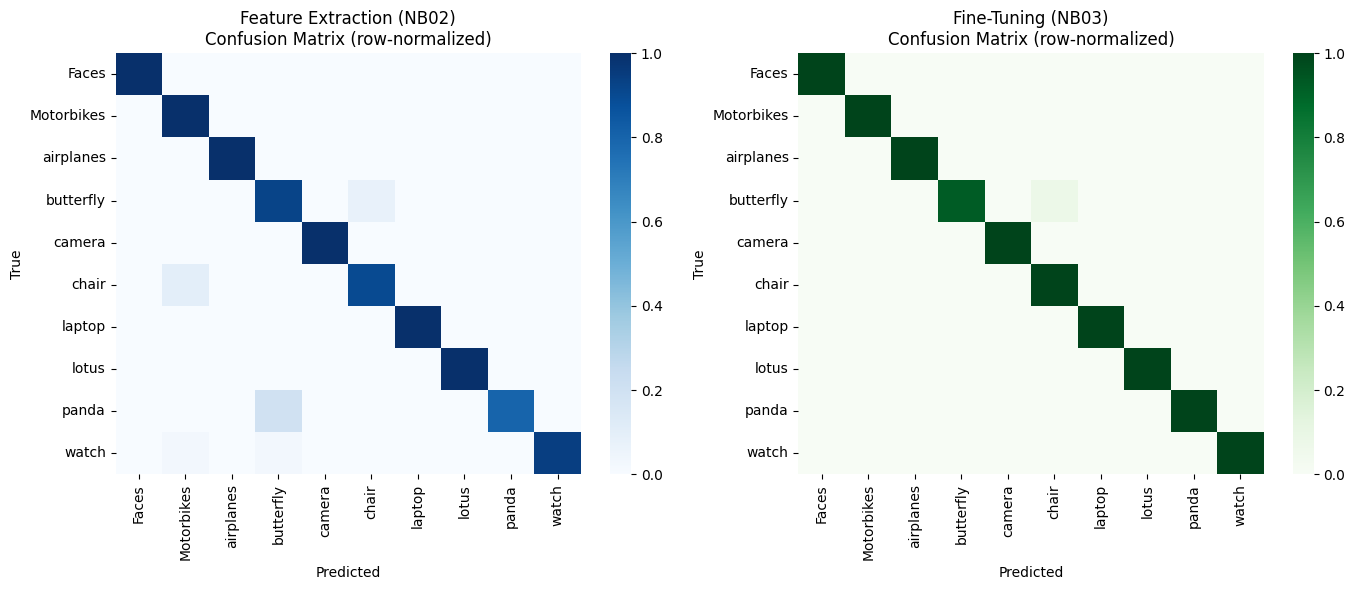

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Row-normalize
cm_fe_norm = cm_fe.astype(float) / cm_fe.sum(axis=1, keepdims=True).clip(min=1)
cm_ft_norm = cm_ft.astype(float) / cm_ft.sum(axis=1, keepdims=True).clip(min=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_fe_norm, cmap="Blues", vmin=0, vmax=1,
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Feature Extraction (NB02)\nConfusion Matrix (row-normalized)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(cm_ft_norm, cmap="Greens", vmin=0, vmax=1,
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Fine-Tuning (NB03)\nConfusion Matrix (row-normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


**Which classes improved the most? (Δ F1 by class)**

In [12]:
from sklearn.metrics import precision_recall_fscore_support

prec_fe, rec_fe, f1_fe, _ = precision_recall_fscore_support(y_true, y_pred_fe, labels=list(range(len(class_names))), zero_division=0)
prec_ft, rec_ft, f1_ft, _ = precision_recall_fscore_support(y_true, y_pred_ft, labels=list(range(len(class_names))), zero_division=0)

delta = f1_ft - f1_fe
per_class = pd.DataFrame({
    "class": class_names,
    "F1_FE": f1_fe,
    "F1_FT": f1_ft,
    "ΔF1": delta
}).sort_values("ΔF1", ascending=False)

print("[per-class ΔF1] Positive values mean fine-tuning improved that class.")
display(per_class)


[per-class ΔF1] Positive values mean fine-tuning improved that class.


,class,F1_FE,F1_FT,ΔF1
8,panda,0.888889,1.000000,0.111111
3,butterfly,0.888889,0.960000,0.071111
5,chair,0.900000,0.952381,0.052381
9,watch,0.971429,1.000000,0.028571
1,Motorbikes,0.973684,1.000000,0.026316
0,Faces,1.000000,1.000000,0.000000
2,airplanes,1.000000,1.000000,0.000000
4,camera,1.000000,1.000000,0.000000
6,laptop,1.000000,1.000000,0.000000
7,lotus,1.000000,1.000000,0.000000


**How to read these comparisons**

 - If **Accuracy** and **Macro F1** increase from FE → FT, fine-tuning helped overall.  
 - Inspect **ΔF1 by class** to see *where* the gains came from. Often, classes with textures or shapes less common in ImageNet benefit more.  
 - The **side-by-side confusion matrices** show whether certain confusions shrank after fine-tuning (rows look “sharper” along the diagonal).

**Why improvement varies**

 - If our dataset is **close to ImageNet** (natural object photos), FE might already be near-optimal, so FT yields **small gains**.  
 - If some categories are **under-represented** or **visually ambiguous**, FT may not help much without augmentation or more data.  
 - If FT underperforms FE, we may need:
   - **Smaller LR** on unfrozen layers,  
   - **Fewer unfrozen layers** (e.g., only part of `layer4`),  
   - **Regularization** or **augmentation**,  
   - **Fewer epochs** to avoid overfitting.

**Key takeaway**  

Fine-tuning adapts the deeper representation to our dataset, but the gains depend on **domain similarity**, **data scale**, and **training choices**. We use these diagnostics to decide whether to push FT further or keep FE as the simpler, stronger baseline.


---

**✅ Code Task 11.3.5.1 – Test accuracy & macro F1 for CT_model**

**Instruction**: Evaluate our CT_model on test_loader and compute
accuracy and macro F1 (use accuracy_score and f1_score).

Store them in `CT_test_acc` and `CT_test_f1`.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

CT_model.eval()
CT_y_true, CT_y_pred = [], []

with torch.no_grad():
    for CT_xb, CT_yb in test_loader:
        CT_xb, CT_yb = CT_xb.to(device), CT_yb.to(device)
        CT_logits = CT_model(CT_xb)
        CT_preds = CT_logits.argmax(dim=1)

        CT_y_true.extend(CT_yb.cpu().numpy().tolist())
        CT_y_pred.extend(CT_preds.cpu().numpy().tolist())

CT_y_true = np.array(CT_y_true)
CT_y_pred = np.array(CT_y_pred)

CT_test_acc = ...
CT_test_f1  = ...

print(f"[CT_Task5] CT_model Test Accuracy: {CT_test_acc:.4f}")
print(f"[CT_Task5] CT_model Macro F1:      {CT_test_f1:.4f}")


**Instructor Solution**

In [15]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

CT_model.eval()
CT_y_true, CT_y_pred = [], []

with torch.no_grad():
    for CT_xb, CT_yb in test_loader:
        CT_xb, CT_yb = CT_xb.to(device), CT_yb.to(device)
        CT_logits = CT_model(CT_xb)
        CT_preds = CT_logits.argmax(dim=1)

        CT_y_true.extend(CT_yb.cpu().numpy().tolist())
        CT_y_pred.extend(CT_preds.cpu().numpy().tolist())

CT_y_true = np.array(CT_y_true)
CT_y_pred = np.array(CT_y_pred)

CT_test_acc = accuracy_score(CT_y_true, CT_y_pred)
CT_test_f1  = f1_score(CT_y_true, CT_y_pred, average="macro")

print(f"[CT_Task5] CT_model Test Accuracy: {CT_test_acc:.4f}")
print(f"[CT_Task5] CT_model Macro F1:      {CT_test_f1:.4f}")


[CT_Task5] CT_model Test Accuracy: 0.9902
[CT_Task5] CT_model Macro F1:      0.9862


In [ ]:
import numpy as np
assert 'CT_test_acc' in globals(), "❌ CT_test_acc missing."
assert 'CT_test_f1' in globals(), "❌ CT_test_f1 missing."
assert isinstance(CT_test_acc, float), "❌ CT_test_acc must be a float."
assert isinstance(CT_test_f1, float), "❌ CT_test_f1 must be a float."
assert 0.0 <= CT_test_acc <= 1.0, "❌ CT_test_acc must be in [0, 1]."
assert 0.0 <= CT_test_f1  <= 1.0, "❌ CT_test_f1 must be in [0, 1]."
print("✅ CT_Task 5 passed!")

---

### **6. Visualizing Feature Adaptation**

To understand **what fine-tuning changed**, we will look inside the network and compare **pre–fine-tuning** (feature extraction, FE) with **post–fine-tuning** (FT) along the last residual stage, `layer4`.

We will visualize two things:

1. **Activation maps** from `layer4` for the *same* image before and after fine-tuning.  
   - If fine-tuning helped, we often see **sharper, more localized activations** over the object of interest or its parts.  
   - If nothing changed, activations may look very similar to the FE case.

2. **Grad-CAM** heatmaps for the **predicted class** before and after fine-tuning.  
   - Grad-CAM highlights the **spatial regions** that contribute most to the model’s decision.  
   - If FT improved performance, Grad-CAM may shift attention from background to **object regions** or attend more strongly to **discriminative parts**.

> Intuition: fine-tuning **adjusts the higher-level perception** of the network. Early layers remain generic (edges, textures), while deeper layers (like `layer4`) become **more specialized** to our 10 Caltech classes, learning to attend to finer boundaries, textures, or parts that matter for those categories.


**Capture layer4 activations (FE vs FT) for one image**

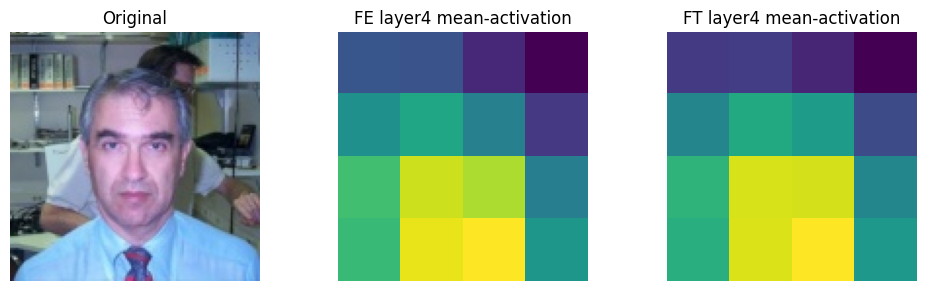

In [21]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Pick one validation image (fixed for reproducibility)
sample_path = val_ds.samples[0][0]  # (path, label)
sample_img = Image.open(sample_path).convert("RGB")

prep = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

x = prep(sample_img).unsqueeze(0).to(device)

# --- Hook helpers ---
acts_fe, acts_ft = {}, {}

def hook_capturer_acts(store_dict, name):
    def hook(_m, _i, o):
        store_dict[name] = o.detach().cpu()
    return hook

# Register hooks on the LAST conv in layer4 (good Grad-CAM target too)
handle_fe = model_fe.layer4.register_forward_hook(hook_capturer_acts(acts_fe, "layer4"))
handle_ft = model.layer4.register_forward_hook(hook_capturer_acts(acts_ft, "layer4"))

# Forward both models
with torch.no_grad():
    _ = model_fe(x)
    _ = model(x)

# Remove hooks
handle_fe.remove()
handle_ft.remove()

# Reduce channel dimension with mean to a single 2D map for each model
# fe_map = acts_fe["layer4"][0].mean(dim=1).squeeze(0)   # [H, W]
# ft_map = acts_ft["layer4"][0].mean(dim=1).squeeze(0)   # [H, W]

# acts_fe["layer4"]: [B, C, H, W]
fe_map = acts_fe["layer4"].mean(dim=1).squeeze(0)  # [H, W]
ft_map = acts_ft["layer4"].mean(dim=1).squeeze(0)  # [H, W]


# Normalize for display
def norm01(t):
    t = t - t.min()
    return t / (t.max().clamp(min=1e-8))

fe_disp = norm01(fe_map).numpy()
ft_disp = norm01(ft_map).numpy()

# Show original + activation maps
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(sample_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(fe_disp, cmap="viridis")
plt.title("FE layer4 mean-activation")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(ft_disp, cmap="viridis")
plt.title("FT layer4 mean-activation")
plt.axis("off")

plt.tight_layout()
plt.show()


**Simple Grad-CAM for layer4 (FE vs FT)**

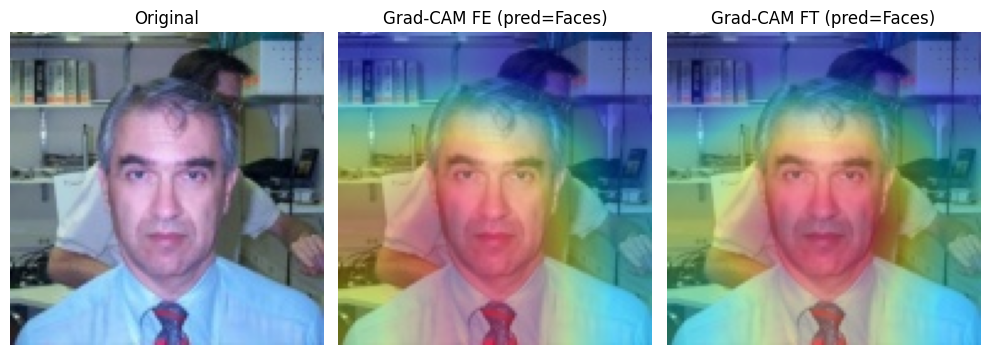

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# ==== 1. Enable grads where we need them for Grad-CAM ====

# For feature-extraction model: everything was frozen; we now allow
# layer4 + fc to have grads so we can compute Grad-CAM.
for p in model_fe.parameters():
    p.requires_grad = False
for p in model_fe.layer4.parameters():
    p.requires_grad = True
for p in model_fe.fc.parameters():
    p.requires_grad = True

# For fine-tuned model: layer4 + fc are already trainable, but we
# explicitly ensure that (harmless if already True).
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

model_fe.eval()
model.eval()

# ==== 2. Grad-CAM helper ====

def gradcam_for_model(model_ref, x_tensor, target_layer):
    """
    Compute Grad-CAM heatmap [H,W] in 0..1 for the model's predicted class.
    """
    model_ref.eval()
    acts = {}
    grads = {}

    # forward hook: save activations
    def fwd_hook(_m, _i, o):
        acts["a"] = o

    # backward hook: save gradients w.r.t. those activations
    def bwd_hook(_m, grad_in, grad_out):
        grads["g"] = grad_out[0]

    # register hooks
    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    # grad-trackable input
    x_local = x_tensor.clone().detach().requires_grad_(True)

    # forward
    logits = model_ref(x_local)             # [1, num_classes]
    pred_idx = logits.argmax(dim=1).item()  # scalar int

    # backward w.r.t. predicted logit
    score = logits[0, pred_idx]
    model_ref.zero_grad(set_to_none=True)
    score.backward()

    # remove hooks
    h1.remove()
    h2.remove()

    # activations & grads: [C,H,W]
    A = acts["a"][0]
    G = grads["g"][0]

    # channel weights = GAP over spatial dims of gradients
    weights = G.mean(dim=(1, 2), keepdim=True)    # [C,1,1]
    cam = (weights * A).sum(dim=0)                # [H,W]

    # ReLU (standard Grad-CAM)
    cam = torch.relu(cam)

    # normalize 0..1
    cam = cam.detach().cpu()
    cam = cam - cam.min()
    cam = cam / cam.max().clamp(min=1e-8)

    return cam.numpy(), pred_idx

# ==== 3. Run Grad-CAM for both models ====

cam_fe, pred_fe = gradcam_for_model(model_fe, x, model_fe.layer4)
cam_ft, pred_ft = gradcam_for_model(model,    x, model.layer4)

# ==== 4. Prepare original (unnormalized) image ====

def unnorm_for_vis(xb):
    mean = np.array([0.485, 0.456, 0.406])[None, None, :]
    std  = np.array([0.229, 0.224, 0.225])[None, None, :]
    img = xb[0].detach().cpu().permute(1, 2, 0).numpy()
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

base_rgb = unnorm_for_vis(x)  # shape: (H, W, 3)

# ==== 5. Overlay utility (with CAM upsampling) ====

def overlay_cam(img, cam, alpha=0.35, cmap="jet"):
    """
    img: (H, W, 3), cam: (h, w) in [0,1].
    We resize cam to (H, W) before blending.
    """
    H, W = img.shape[:2]

    if cam.shape != (H, W):
        # upsample CAM using bilinear interpolation
        cam_t = torch.from_numpy(cam).float().unsqueeze(0).unsqueeze(0)  # [1,1,h,w]
        cam_t = F.interpolate(cam_t, size=(H, W), mode="bilinear", align_corners=False)
        cam = cam_t.squeeze().cpu().numpy()  # [H,W]

    heat = plt.get_cmap(cmap)(cam)[..., :3]   # RGBA -> RGB
    return (1 - alpha) * img + alpha * heat

ovl_fe = overlay_cam(base_rgb, cam_fe)
ovl_ft = overlay_cam(base_rgb, cam_ft)

# ==== 6. Plot ====

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(base_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ovl_fe)
plt.title(f"Grad-CAM FE (pred={class_names[pred_fe]})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ovl_ft)
plt.title(f"Grad-CAM FT (pred={class_names[pred_ft]})")
plt.axis("off")

plt.tight_layout()
plt.show()


**Reading the activation maps (mean over channels)**

 - If the **FT map** looks more concentrated on the object or its parts than the FE map, that suggests `layer4` has adapted to **more discriminative regions**.  
 - If both maps look similar, the feature extraction representation may already be strong for this sample.

**Reading the Grad-CAM overlays**

 - Grad-CAM highlights **where** the model looks to make its decision.  
 - After fine-tuning, attention often shifts **away from background** and toward **object boundaries or distinctive textures**.  
 - If the predicted class changes from FE → FT (and becomes correct), check whether FT’s CAM aligns better with **true object regions**.

**Why this matters**

 - These visualizations connect **performance gains** to **representational changes**.  
 - Fine-tuning does not rewrite the whole network; it **nudges higher-level features** to better fit our dataset.  
 - When the target dataset diverges from ImageNet, these nudges can be the difference between **ambiguous** and **decisive** internal representations.


---

### **7. Reflection: When to Fine-Tune (and When Not To)**

Fine-tuning is a powerful tool — but not always the best choice.  
Here, we step back to think about **when it makes sense** to unfreeze pretrained layers and **when it’s better** to keep them frozen.


🧠 When **Feature Extraction** Is Sufficient
Feature extraction (keeping the backbone frozen) often works best when:
- The **dataset is small**, and we risk overfitting if we train too many parameters.  
- The **target domain is similar** to ImageNet — for example, natural photographs of everyday objects.  
- We need **fast training** and **stable convergence**.  
- The goal is to build a **strong baseline** with minimal computation.

> Think of it as using an already trained “visual encoder” and only teaching the model how to map features to new labels.

⚙️ When **Fine-Tuning** Helps
Fine-tuning pays off when:
- We have **enough data** to adjust deeper weights meaningfully.  
- The **domain differs** from ImageNet (e.g., microscopic images, artworks, X-rays, or unusual textures).  
- We need to **squeeze out extra accuracy** beyond the frozen baseline.  
- We are studying **representation specialization** — how features evolve for new tasks.

> In such cases, fine-tuning allows the deeper convolutional filters to “shift” toward the new dataset’s structure — learning domain-specific color palettes, shapes, or boundary cues.

**⚖️ Trade-offs**
| Aspect | Feature Extraction | Fine-Tuning |
|:--|:--|:--|
| **Training time** | Short | Longer |
| **Data requirement** | Low | Higher |
| **Risk of overfitting** | Low | Higher |
| **Adaptability** | Limited | Greater |
| **Computation cost** | Low | Higher |

Fine-tuning can yield **better adaptation** but at the cost of **extra computation** and potential **loss of generality** — the network may “forget” some of its broad ImageNet knowledge if learning rates are too high.

**💬 For Reflection**

- Did we observe **meaningful gains** in accuracy or F1 from fine-tuning?  
- Were the **extra epochs and compute** worth the improvement?  
- For our dataset, is the **domain shift** large enough to justify fine-tuning?  
- If not, might **feature extraction alone** already generalize well enough?


> **Key takeaway:**  
> Fine-tuning is not a default next step — it’s a **strategic decision**.  
> We use it **only when the data, domain, and goals** justify the added complexity.
>
> In the next (and final) section, we’ll save our fine-tuned model for reuse and summarize what we’ve learned across the entire mini-project.


---

### **8. Saving the Fine-Tuned Model**

Now that we’ve completed training and evaluation, let’s save the key artifacts from our fine-tuning experiment.

We will store:

- The **fine-tuned model weights** as `resnet18_finetuned.pth`.  
- The **training and validation logs** (losses, accuracies) as `training_logs_finetuned.json`.

These files will allow us to **reload the fine-tuned model in NB04** — where we’ll make side-by-side visual and quantitative comparisons across all three stages:

1. Pretrained (ImageNet-only)  
2. Feature Extracted (NB02)  
3. Fine-Tuned (NB03)

This continuity helps us trace **how representations evolve** through each stage of adaptation.


**Save Fine-Tuned Model and Logs**

In [20]:
import torch
import json
from pathlib import Path

save_dir = Path("./checkpoints")
save_dir.mkdir(exist_ok=True, parents=True)

# Save the fine-tuned model weights
ft_ckpt_path = save_dir / "resnet18_finetuned.pth"
torch.save(model.state_dict(), ft_ckpt_path)

# Save the training history (loss/accuracy)
history_ft = {
    "train_loss": ft_history["train_loss"],
    "val_loss": ft_history["val_loss"],
    "val_acc": ft_history["val_acc"],
}
with open(save_dir / "training_logs_finetuned.json", "w") as f:
    json.dump(history_ft, f, indent=4)

print(f"[done] Saved fine-tuned model → {ft_ckpt_path}")
print(f"[done] Saved training logs → {save_dir / 'training_logs_finetuned.json'}")


[done] Saved fine-tuned model → checkpoints\resnet18_finetuned.pth
[done] Saved training logs → checkpoints\training_logs_finetuned.json


---

**✅ Code Task 11.3.8.1 – Save our fine-tuned CT_model for reuse**

Save the state dictionary of `CT_model` (created and trained in the codes tasks in this notebook so far) into a file so that we can load it in the next notebook.
Use a variable named `CT_SAVE_PATH` for the filename, and call `torch.save` on `CT_model.state_dict()`.

In [ ]:
import torch

# Path where we will save our fine-tuned model
CT_SAVE_PATH = "..."  # e.g. "resnet18_layer34_ct_finetuned.pth"

# Save only the state dict of CT_model
...
print(f"[CT_Task6] Saved CT_model weights to: {CT_SAVE_PATH}")


**Instructor Solution**

In [ ]:
import torch

CT_SAVE_PATH = "resnet18_layer34_ct_finetuned_NB03.pth"

torch.save(CT_model.state_dict(), CT_SAVE_PATH)
print(f"[CT_Task6] Saved CT_model weights to: {CT_SAVE_PATH}")

[CT_Task6] Saved CT_model weights to: resnet18_layer34_ct_finetuned.pth


In [ ]:
import os
import torch

assert 'CT_SAVE_PATH' in globals(), "❌ CT_SAVE_PATH not defined."
assert isinstance(CT_SAVE_PATH, str), "❌ CT_SAVE_PATH must be a string."

assert os.path.exists(CT_SAVE_PATH), f"❌ File '{CT_SAVE_PATH}' does not exist. Did you call torch.save?"

# Try loading the file to ensure it is a valid checkpoint
CT_loaded_state = torch.load(CT_SAVE_PATH, map_location="cpu", weights_only=False)
assert isinstance(CT_loaded_state, dict), "❌ Loaded checkpoint is not a state_dict (expected a dict)."
assert len(CT_loaded_state) > 0, "❌ Loaded state_dict seems to be empty."

print("✅ CT_Task 6 passed!")

---

### **9. Summary and Transition to NB04**

In this notebook, we took a major conceptual and practical step forward.

**🔁 What We Did**
- Reloaded the **feature extraction** model and **unfroze** the last block (`layer4`) for fine-tuning.  
- Used a **smaller learning rate** to adjust deeper weights carefully.  
- Compared performance and **visualized feature adaptation** through activation maps and Grad-CAM.  
- Reflected on when fine-tuning is valuable and when it may not be worth the cost.

**📈 What We Learned**
- Fine-tuning allows a model to **specialize** to the target dataset’s structure — especially when the domain differs from ImageNet.  
- However, its benefits depend on **data availability**, **domain shift**, and **regularization**.  
- We confirmed that while feature extraction provides a strong baseline, fine-tuning can yield **sharper feature attention** and improved classification for difficult classes.

**🚀 What’s Next (NB04)**
In the next notebook, we’ll:
- **Compare all three models** — pretrained, feature-extracted, and fine-tuned — side by side.  
- Visualize **predictions, Grad-CAMs, and performance metrics** together.  
- Discuss **efficiency vs. accuracy** and reflect on **ethical implications** of reusing large pretrained models in applied tasks.

> With this, we’ve completed the practical journey from **transfer learning setup to fine-tuned adaptation** — a key progression in modern deep learning practice.
